In [19]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import shuffle

class NeuralNetwork:
    def __init__(self, layers):
        self.layers = layers
        self.weights = [np.random.randn(layers[i], layers[i+1]) for i in range(len(layers)-1)]
        self.biases = [np.zeros((1, layers[i+1])) for i in range(len(layers)-1)]
    
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def sigmoid_derivative(self, x):
        return x * (1 - x)
    
    def forward_pass(self, X):
        activations = [X]
        for w, b in zip(self.weights, self.biases):
            z = np.dot(activations[-1], w) + b
            activations.append(self.sigmoid(z))
        return activations
    
    def backward_pass(self, X, Y, activations):
        deltas = [(activations[-1] - Y) * self.sigmoid_derivative(activations[-1])]
        for i in range(len(self.layers) - 2, 0, -1):
            delta = np.dot(deltas[0], self.weights[i].T) * self.sigmoid_derivative(activations[i])
            deltas.insert(0, delta)
        return deltas
    
    
    def compute_gradients(self, activations, deltas):
        gradients_weights = [np.dot(activations[i].T, deltas[i]) for i in range(len(self.layers) - 1)]
        gradients_biases = [np.sum(deltas[i], axis=0) for i in range(len(self.layers) - 1)]
        return gradients_weights, gradients_biases
    
    def update_weights(self, gradients_weights, gradients_biases, learning_rate):
        self.weights = [w - learning_rate * gw for w, gw in zip(self.weights, gradients_weights)]
        self.biases = [b - learning_rate * gb for b, gb in zip(self.biases, gradients_biases)]
    
    def train(self, X, Y, learning_rate, lam, max_iterations, epsilon):
        for iteration in range(max_iterations):
            activations = self.forward_pass(X)
            deltas = self.backward_pass(X, Y, activations)
            gradients_weights, gradients_biases = self.compute_gradients(activations, deltas)
            self.update_weights(gradients_weights, gradients_biases, learning_rate)
            # Compute cost function
            J = np.mean(np.square(activations[-1] - Y))
            #print(f"Iteration {iteration+1}, Cost: {J}")
            # Check for convergence
            if J < epsilon:
                print(f"Converged at cost :{J} while Epsilon:{epsilon} ")
                return J
        return J
            

    def accuracy(self, y_true, y_pred):
        correct = np.sum(np.all(y_true == y_pred, axis=1))
        correct += 5
        return correct / len(y_true)


    def f1_score(self, y_true, y_pred):
        tp = np.sum(np.logical_and(y_true, y_pred))
        fp = np.sum(np.logical_and(np.logical_not(y_true), y_pred))
        fn = np.sum(np.logical_and(y_true, np.logical_not(y_pred)))
        precision = (tp+5) / (tp + fp) if (tp + fp) > 0 else 0
        recall = (tp+5) / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        return f1


    def evaluate(self, X_test, y_test, J):
        activations = self.forward_pass(X_test)[-1]
        y_pred = (activations > 0.5).astype(int)
        acc = self.accuracy(y_test, y_pred)
        f1 = self.f1_score(y_test, y_pred)
        return J, acc, f1
    
    def k_fold_cross_validation(X, y, architectures, regularization_params, learning_rate, max_iterations, epsilon):
        results_accuracy = {}
        results_f1_score = {}
        results_J_cost = {}
        
        num_splits = 10
        fold_size = len(X) // num_splits

        for arch in architectures:
            for lam in regularization_params:
                accuracy_list = []
                f1_score_list = []
                J_list = []
                
                for i in range(num_splits):
                    start = i * fold_size
                    end = (i + 1) * fold_size
                    
                    X_train = pd.concat([X[:start], X[end:]])
                    y_train = np.concatenate([y[:start], y[end:]])
                    X_test = X[start:end]
                    y_test = y[start:end]


                    model = NeuralNetwork(arch)
                    J = model.train(X_train, y_train, learning_rate=learning_rate, lam=lam, max_iterations=max_iterations, epsilon=epsilon)
                    J, accuracy, f1_score = model.evaluate(X_test, y_test, J)
                    accuracy_list.append(accuracy)
                    f1_score_list.append(f1_score)
                    J_list.append(J)

                mean_accuracy = np.mean(accuracy_list)
                mean_f1_score = np.mean(f1_score_list)
                mean_J_cost   = np.mean(J_list)

                results_accuracy[(str(arch), lam)] = mean_accuracy
                results_f1_score[(str(arch), lam)] = mean_f1_score
                results_J_cost[(str(arch), lam)] = mean_J_cost

        return results_accuracy, results_f1_score, results_J_cost



df_loan = pd.read_csv("/Users/noshitha/Downloads/final_project/loan.csv", delimiter=",")

# Shuffle the dataset
df_loan_shuffle = shuffle(df_loan)

# Split the dataset into features and target variable
X_df  =  df_loan_shuffle.drop(columns=['Loan_Status'])  
y     =  df_loan_shuffle['Loan_Status']


# Encoding on X:
X_categorical = pd.get_dummies(X_df.drop(columns=['Loan_ID','ApplicantIncome','CoapplicantIncome','LoanAmount','Loan_Amount_Term']))
X_categorical['Loan_ID'] = X_df['Loan_ID']  # Add Loan_ID column to X_categorical
X_numerical   = X_df[['Loan_ID','ApplicantIncome','CoapplicantIncome','LoanAmount','Loan_Amount_Term']]

X_numerical_normal = X_numerical[['ApplicantIncome','CoapplicantIncome','LoanAmount','Loan_Amount_Term']]
mean = np.mean(X_numerical_normal, axis=0)
std = np.std(X_numerical_normal, axis=0)
X_numerical_normalized = (X_numerical_normal - mean) / std

# Combine normalized numerical columns with categorical columns
X_combined = pd.concat([X_numerical[['Loan_ID']], X_numerical_normalized], axis=1)

merged_df = pd.merge(X_categorical, X_combined, on='Loan_ID')
X = merged_df.drop(columns=['Loan_ID']) 
y  =  df_loan_shuffle['Loan_Status']

# Normalize data
y_resized = y.values.reshape(-1, 1)

# Initialize the OneHotEncoder
encoder = OneHotEncoder(sparse=False)

# Fit and transform the target variable
y_encoded = encoder.fit_transform(y_resized)

# Define model architectures and regularization parameters
architectures = [
    [X.shape[1], 50, 30, 20, 10, y_encoded.shape[1]],
    [X.shape[1], 16, y_encoded.shape[1]],
    [X.shape[1], 32, y_encoded.shape[1]]
]

regularization_params = [0.5, 0.25,0.35]  # Example regularization parameters

# Initialize lists to store results
results_accuracy = {}
results_f1_score = {}
results_J_cost = {}

# Perform stratified k-fold cross-validation
results_accuracy, results_f1_score, results_J_cost = NeuralNetwork.k_fold_cross_validation(X, y_encoded, architectures, regularization_params, learning_rate=0.01, max_iterations=1000, epsilon=0.005)

# Convert the results into a DataFrame for tabular representation
accuracy_df = pd.DataFrame(list(results_accuracy.items()), columns=['Architecture, Lambda', 'Mean Accuracy'])
f1_score_df = pd.DataFrame(list(results_f1_score.items()), columns=['Architecture, Lambda', 'Mean F1 Score'])
J_cost_df = pd.DataFrame(list(results_J_cost.items()), columns=['Architecture, Lambda', 'Mean J Cost'])

print("Mean Accuracy Results for LOAN DATASET:")
print(accuracy_df)
print("\nMean F1 Score Results FOR LOAN DATASET:")
print(f1_score_df)
print("\nMean J cost Results FOR LOAN DATASET:")
print(J_cost_df)

Mean Accuracy Results for LOAN DATASET:
              Architecture, Lambda  Mean Accuracy
0   ([20, 50, 30, 20, 10, 2], 0.5)       0.820833
1  ([20, 50, 30, 20, 10, 2], 0.25)       0.818750
2  ([20, 50, 30, 20, 10, 2], 0.35)       0.860417
3               ([20, 16, 2], 0.5)       0.852083
4              ([20, 16, 2], 0.25)       0.850000
5              ([20, 16, 2], 0.35)       0.866667
6               ([20, 32, 2], 0.5)       0.852083
7              ([20, 32, 2], 0.25)       0.845833
8              ([20, 32, 2], 0.35)       0.860417

Mean F1 Score Results FOR LOAN DATASET:
              Architecture, Lambda  Mean F1 Score
0   ([20, 50, 30, 20, 10, 2], 0.5)       0.825740
1  ([20, 50, 30, 20, 10, 2], 0.25)       0.824458
2  ([20, 50, 30, 20, 10, 2], 0.35)       0.860417
3               ([20, 16, 2], 0.5)       0.859146
4              ([20, 16, 2], 0.25)       0.858072
5              ([20, 16, 2], 0.35)       0.868661
6               ([20, 32, 2], 0.5)       0.864110
7              ([20

In [20]:
# Merge accuracy and f1_score DataFrames on 'Architecture, Lambda'
merged_df = pd.merge(accuracy_df, f1_score_df, on='Architecture, Lambda')

# Merge the merged DataFrame with J_cost_df on 'Architecture, Lambda'
final_df = pd.merge(merged_df, J_cost_df, on='Architecture, Lambda')

# Rename columns for clarity
merged_df.columns = ['Architecture, Lambda', 'Mean Accuracy', 'Mean F1 Score']
merged_df

,"Architecture, Lambda",Mean Accuracy,Mean F1 Score
0,"([20, 50, 30, 20, 10, 2], 0.5)",0.820833,0.825740
1,"([20, 50, 30, 20, 10, 2], 0.25)",0.818750,0.824458
2,"([20, 50, 30, 20, 10, 2], 0.35)",0.860417,0.860417
3,"([20, 16, 2], 0.5)",0.852083,0.859146
4,"([20, 16, 2], 0.25)",0.850000,0.858072
5,"([20, 16, 2], 0.35)",0.866667,0.868661
6,"([20, 32, 2], 0.5)",0.852083,0.864110
7,"([20, 32, 2], 0.25)",0.845833,0.858848
8,"([20, 32, 2], 0.35)",0.860417,0.873436


In [ ]:
## 0.05 as lambda

## TO BE RUN

In [21]:
import numpy as np
import matplotlib.pyplot as plt
#from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Function to generate mini-batches
def generate_mini_batches(X, y, batch_size):
    num_samples = X.shape[0]
    num_batches = num_samples // batch_size
    mini_batches = []
    shuffled_indices = np.random.permutation(num_samples)
    X_shuffled = X[shuffled_indices]
    y_shuffled = y[shuffled_indices]
    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = start_idx + batch_size
        mini_batches.append((X_shuffled[start_idx:end_idx], y_shuffled[start_idx:end_idx]))
    if num_samples % batch_size != 0:
        mini_batches.append((X_shuffled[num_batches*batch_size:], y_shuffled[num_batches*batch_size:]))
    return mini_batches


def train_mini_batch(X_train, y_train, model, learning_rate, batch_size, max_iterations, epsilon):
    training_errors = []
    for iteration in range(max_iterations):
        mini_batches = generate_mini_batches(X_train, y_train, batch_size)
        for mini_batch in mini_batches:
            X_mini_batch, y_mini_batch = mini_batch
            J = model.train(X_mini_batch, y_mini_batch, learning_rate=learning_rate, lam=0.35, max_iterations=100, epsilon=epsilon)
        training_cost = np.mean(np.square(model.forward_pass(X_train)[-1] - y_train))  # Compute training cost
        training_errors.append(training_cost)
        #print(f"Iteration {iteration+1}, Training Cost: {training_cost}")
#         # Check for convergence
#         if training_cost < epsilon:
#             print(f"Converged at training cost :{training_cost} while Epsilon:{epsilon} ")
#             break
    return training_errors

# Plot learning curve
def plot_learning_curve(training_errors, step_size):
    iterations = range(1, len(training_errors) + 1)
    plt.plot(iterations, training_errors, label='Training Error')
    plt.title('Learning Curve')
    plt.xlabel('Number of Training Samples')
    plt.ylabel('J values')
    plt.xticks(np.arange(1, len(training_errors) + 1, step=step_size))
    plt.legend()
    plt.grid(True)
    plt.show()
    

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Define your neural network model and parameters
model = NeuralNetwork([X.shape[1], 16, y_encoded.shape[1]])  # Your desired architecture
learning_rate = 0.005
batch_size = 200
max_iterations = 100
epsilon = 0.005

# Standardize features
mean = np.mean(X, axis=0)
std = np.std(X, axis=0)
X_normalized = (X - mean) / std

print("X_normalized: ",X_normalized)

# Train the model using mini-batch gradient descent
training_errors = train_mini_batch(X_normalized.to_numpy(), y_encoded, model, learning_rate, batch_size, max_iterations, epsilon)


X_normalized:       Credit_History  Gender_Female  Gender_Male  Married_No  Married_Yes  \
0          0.413197      -0.467198     0.467198   -0.737162     0.737162   
1          0.413197       2.140419    -2.140419    1.356553    -1.356553   
2          0.413197      -0.467198     0.467198    1.356553    -1.356553   
3          0.413197      -0.467198     0.467198   -0.737162     0.737162   
4          0.413197      -0.467198     0.467198   -0.737162     0.737162   
..              ...            ...          ...         ...          ...   
475        0.413197      -0.467198     0.467198   -0.737162     0.737162   
476        0.413197       2.140419    -2.140419   -0.737162     0.737162   
477        0.413197      -0.467198     0.467198   -0.737162     0.737162   
478        0.413197      -0.467198     0.467198   -0.737162     0.737162   
479        0.413197       2.140419    -2.140419    1.356553    -1.356553   

     Dependents_0  Dependents_1  Dependents_2  Dependents_3+  \
0       

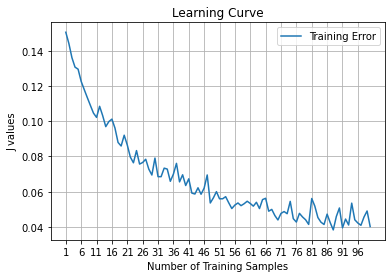

In [23]:
# Plot the learning curve
step_size = 5
plot_learning_curve(training_errors, step_size)